In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier

from matplotlib import pyplot as plt
import numpy as np



from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

In [7]:
models = [
    RandomForestClassifier(n_estimators=130, random_state=1),
    xgb.XGBClassifier(n_estimators=140, eval_metric='logloss', random_state=1),
    LogisticRegression(C=10000000),
    SVC(kernel='rbf', probability=True),
    KNeighborsClassifier(n_neighbors=9),
]

small_models = [RandomForestClassifier(n_estimators=130, random_state=1),
                xgb.XGBClassifier(n_estimators=140, eval_metric='logloss', random_state=1),
                ]

In [9]:
from sklearn.metrics import roc_auc_score

from evaluateClassifier import tprAtFPR


desiredFPR = 0.01
trainDataFilename = 'spamTrain1.csv'

def eval_model(pipeline):
    data = np.loadtxt(trainDataFilename,delimiter=',')
    trainData, testData = np.split(data, 2, axis=0)

    shuffleIndex = np.arange(np.shape(trainData)[0])
    np.random.shuffle(shuffleIndex)
    trainData = trainData[shuffleIndex,:]
    trainFeatures = trainData[:,:-1]
    trainLabels = trainData[:,-1]

    shuffleIndex = np.arange(np.shape(testData)[0])
    np.random.shuffle(shuffleIndex)
    testData = testData[shuffleIndex,:]
    testFeatures = testData[:,:-1]
    testLabels = testData[:,-1]

    pipeline.fit(trainFeatures,trainLabels)
    testOutputs = pipeline.predict_proba(testFeatures)[:,1]

    aucTestRun = roc_auc_score(testLabels,testOutputs)
    tprAtDesiredFPR,fpr,tpr = tprAtFPR(testLabels,testOutputs,desiredFPR)

    classifier_name = list(pipeline.named_steps.keys())[-1]

    plt.plot(fpr,tpr, label=classifier_name)

    print(f'{classifier_name} | AUC: {aucTestRun} | TPR at FPR = {desiredFPR}: {tprAtDesiredFPR}')


c:\Users\bdsoc\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


clf | AUC: 0.8834657919262634 | TPR at FPR = 0.01: 0.3268608414239482


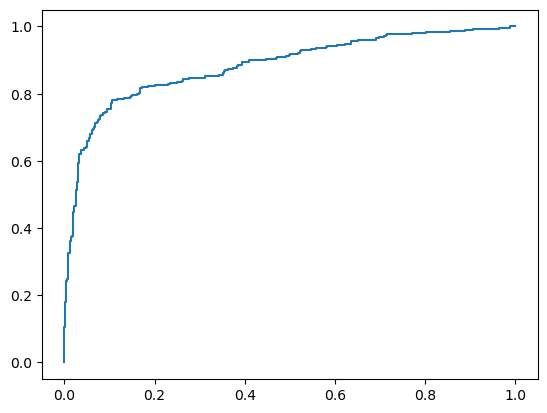

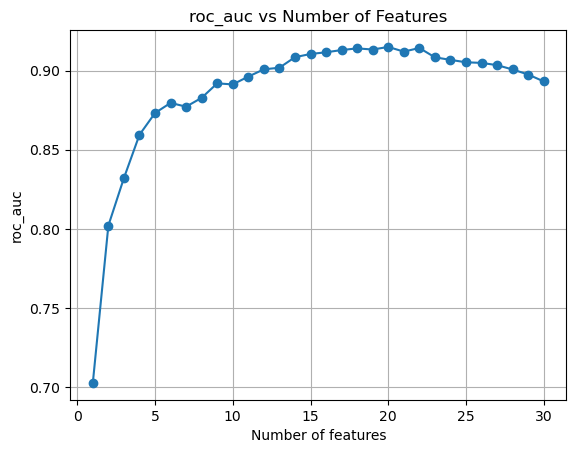

In [13]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.pipeline import Pipeline

model = xgb.XGBClassifier(n_estimators=140, eval_metric='logloss', random_state=1)
pipeline = Pipeline([
            ('scaler', StandardScaler()),  # StandardScaler as a preprocessing step (optional)
            ('sbs', SFS(model,
                        k_features='best',  # Select features until reaching 1
                        forward=False,      # Backward selection
                        scoring='roc_auc',
                        n_jobs=-1)),
            ('clf', model)
            ])

eval_model(pipeline)
plt.show()

sbs = pipeline.named_steps['sbs']
# Get the results (accuracy and number of features)
k_feat = [k for k in sbs.subsets_]
scores = [sbs.subsets_[k]['avg_score'] for k in sbs.subsets_]

# Plot accuracy vs number of features
plt.plot(k_feat, scores, marker='o')
plt.xlabel('Number of features')
plt.ylabel(f'roc_auc')
plt.title(f'roc_auc vs Number of Features')
plt.grid()
plt.show()

In [16]:
from sklearn.model_selection import train_test_split


train1DataFilename = 'spamTrain1.csv'
train2DataFilename = 'spamTrain2.csv'

data1 = np.loadtxt(train1DataFilename,delimiter=',')
data2 = np.loadtxt(train2DataFilename,delimiter=',')

data = np.r_[data1,data2]
X = data[:, :-1]
y = data[:, -1]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

selected_feature_indices = sbs.k_feature_idx_

X_train_sfs = X_train[:, selected_feature_indices]  # Training set with selected features
X_test_sfs = X_test[:, selected_feature_indices]

In [17]:
model.fit(X_train_sfs, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=140,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

In [18]:
import xgboost as xgb

class xgb_model():
    def __str__(self):
        return f"xgboost (140 estimators)"
    


    def predictTest(self, trainFeatures,trainLabels,testFeatures):        
        # Use predict_proba() rather than predict() to use probabilities rather
        # than estimated class labels as outputs
        testOutputs = model.predict_proba(X_test_sfs)[:,1]
        
        return testOutputs

num features 20
xgboost (140 estimators) | AUC: 0.8888489667242317 | TPR at FPR = 0.01: 0.35564853556485354


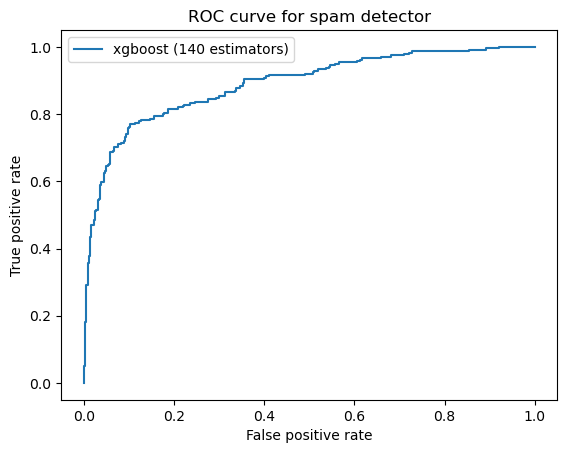

In [21]:
from evaluateClassifier import evalModel

print(f'num features {len(selected_feature_indices)}')
evalModel([xgb_model()])

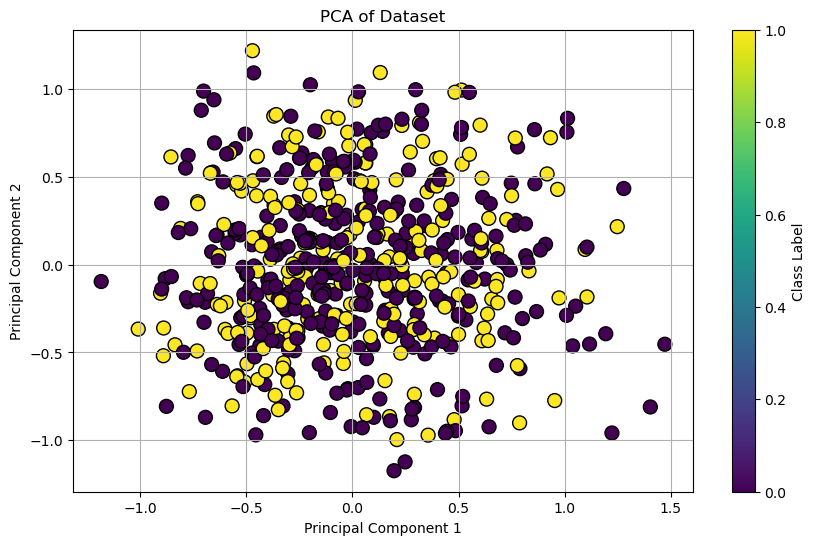

In [24]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_sfs)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_test, cmap='viridis', edgecolor='k', s=100)
plt.title('PCA of Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Class Label')
plt.grid()
plt.show()